# Assignment 7: Policy Gradients

## 2. Data, OpenAI Gym

In [1]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'gym'

In [2]:
# create new environment instance
env = gym.make("CartPole-v0")

for episode in range(100):
    # reset game
    observation = env.reset()
    done = False
    
    while not done:
        # render current game state every 10th step
        if episode % 10 == 0:
            env.render()
        
        # create a random action
        action = env.action_space.sample()
        # execute action and receive the corresponding reward and a new observation
        observation, reward, done, info = env.step(action)

## 3. Network structure

In [3]:
tf.reset_default_graph()
tf.set_random_seed(0)

# define placeholder
inputs = tf.placeholder(tf.float32, [1, 4])

with tf.name_scope("fully-connected"):
    weights = tf.get_variable("weights", [4, 8], tf.float32, initializer=tf.random_normal_initializer(stddev=2.0))
    biases = tf.get_variable("biases", [8], tf.float32, initializer=tf.constant_initializer(0.1))
    activations = tf.nn.relu(tf.matmul(inputs, weights) + biases)

with tf.name_scope("output"):
    weight = tf.get_variable("weight", [8, 1], tf.float32, initializer=tf.random_normal_initializer(stddev=0.25))
    bias = tf.get_variable("bias", [1], tf.float32, initializer=tf.constant_initializer(0.0))
    action_probability = tf.sigmoid(tf.matmul(activations, weight) + bias)

# calc log likelihoods from probability distribution of both actions
log_likelihoods = tf.log(tf.concat([action_probability, 1 - action_probability], axis=1))

# sample an action from distribution
action = tf.multinomial(log_likelihoods, num_samples=1)[0][0]

# select value that corresponds to selected action
log_likelihood = log_likelihoods[:, tf.to_int32(action)]

## 4. Gradients

In [4]:
# training hyper-parameters
episodes = 10
batches = 40
init_learning_rate = 0.1
discount_factor = 0.98

In [5]:
# exponential decaying learning rate
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(init_learning_rate, global_step, 100, 0.3)
optimizer = tf.train.AdamOptimizer(learning_rate)

# compute gradients
gradients_and_variables = optimizer.compute_gradients(log_likelihood)
gradients = [gradient_and_variable[0] * -1 for gradient_and_variable in gradients_and_variables]

# create placeholders
gradient_placeholders = []
for gradient in gradients:
    gradient_placeholders.append(tf.placeholder(tf.float32, gradient.shape))

# apply gradients
trainable_variables = tf.trainable_variables()
train = optimizer.apply_gradients(zip(gradient_placeholders, trainable_variables), global_step=global_step)

## 5. Episode, Discounted Rewards, Policy Gradients

In [6]:
reward_history = []

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for _ in range(batches):
    policy_gradients = []
    
    for _ in range(episodes):
        # reset game
        observation = env.reset()
        rewards = []
        grads = []
        done = False
        train_step = 0

        while not done:
            # calc action and log likelihood
            output, grad = sess.run([action, gradients], feed_dict={inputs: [observation]})
            observation, reward, done, info = env.step(output)
            
            # buffer rewards and gradients
            rewards.append(reward)
            grads.append(grad)

            train_step += 1

        # discount and normalize rewards
        reward_history.append(np.sum(rewards))
        rewards = [rewards[i] * discount_factor**i for i in range(train_step)]
        rewards = (rewards - np.mean(rewards)) / np.std(rewards)

        # calc policy gradients
        grads = [np.asarray(grads[i]) * rewards[i] for i in range(train_step)]
        policy_gradients.append(np.sum(grads, axis=0))
    
    # apply policy gradients
    for grads in policy_gradients:
        sess.run(train, feed_dict={gradient_placeholders[0]: grads[0],
                                   gradient_placeholders[1]: grads[1],
                                   gradient_placeholders[2]: grads[2],
                                   gradient_placeholders[3]: grads[3]})

sess.close()

## 9. Plotting

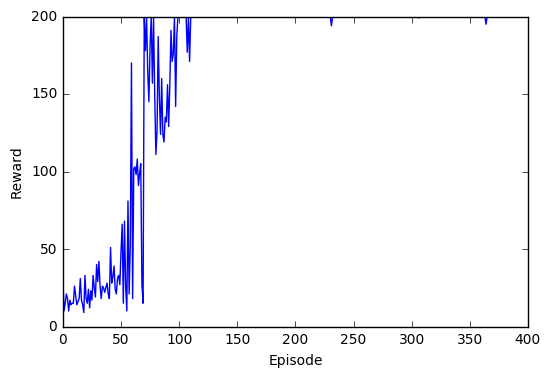

In [7]:
# plot reward over episodes
plt.plot(range(batches * episodes), reward_history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()